In [1]:
%matplotlib inline

import numpy as np
import torch
from torch import Tensor
from torch.autograd import Variable
import torch.optim as opt
import tensorflow as tf
import gym

import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')

[2017-07-28 10:36:03,469] Making new env: CartPole-v0


In [3]:
gamma = 0.99
lr = 0.05
hidden = 8
num_action = env.action_space.n
num_state = env.observation_space.shape[0]

In [4]:
def discount_rewards(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [43]:
tf.reset_default_graph()

x = tf.placeholder(dtype=tf.float32,shape=[None,num_state])
w1 = tf.Variable(np.random.randn(num_state,hidden),name='w1',dtype=tf.float32)
b1 = tf.Variable(np.random.randn(1,hidden),name='b1',dtype=tf.float32)
layer1 = tf.nn.relu(tf.matmul(x,w1) + b1)
w2 = tf.Variable(np.random.randn(hidden,num_action),name='w2',dtype=tf.float32)
b2 = tf.Variable(np.random.randn(1,num_action),name='b2',dtype=tf.float32)
layer2 = tf.nn.sigmoid(tf.matmul(layer1,w2) + b2)
output = tf.nn.softmax(layer2)

chosen_action = tf.argmax(output,axis=1)

action_holder = tf.placeholder(tf.float32,[None,num_action])
reward_holder = tf.placeholder(tf.float32,[None])

cost = -tf.reduce_mean(tf.log(tf.reduce_sum(output * action_holder,axis=1)) * 
                      reward_holder)

gradient_holders = []
tvars = tf.trainable_variables()
for idx,var in enumerate(tvars):
    ph = tf.placeholder(tf.float32,name=str(idx)+'_holder')
    gradient_holders.append(ph)
    
grad = tf.gradients(cost,tvars)
opt = tf.train.AdamOptimizer(lr)
update = opt.apply_gradients(zip(gradient_holders,tvars))

In [14]:
e = 0.1
epoch = 10000
init = tf.global_variables_initializer()
amap = np.identity(num_action)

with tf.Session() as sess:
    sess.run(init)
    
    gradient_buffer = sess.run(tf.trainable_variables())
    for ix,gd in enumerate(gradient_buffer):
        gradient_buffer[ix] = grad * 0
    
    for i in range(epoch):
        s = env.reset()
        done = False
        total_reward = 0
        s_hist = []
        a_hist = []
        r_hist = []
        while not done:
            a = sess.run(chosen_action,{x:np.array([s])})
            if np.random.rand() < e:
                a[0] = env.action_space.sample()
            s1,r,done,_ = env.step(a[0])
            s_hist.append(s)
            a_hist.append(amap[a[0]:a[0]+1][0])
            r_hist.append(r)
            total_reward += r
            if done:
                s_h = np.array(s_hist,dtype=np.float32)
                a_h = np.array(a_hist,dtype=np.float32)
                r_h = discount_rewards(np.array(r_hist,dtype=np.float32))
                c,g = sess.run([cost,grad],{x:s_h,action_holder:a_h,reward_holder:r_h})

                for ix,gd in enumerate(g):
                    gradient_buffer[ix] += gd
                    
                if i % 1000 == 0:
                    sess.run(update,feed_dict=dict(zip(gradient_holders, gradient_buffer)))
                    for ix,gd in enumerate(g):
                        gradient_buffer[ix] = 0
                    print total_reward
            s = s1

14.0
11.0
10.0
12.0
9.0
10.0
10.0
10.0
10.0
11.0


In [47]:
total_episodes = 5000
max_ep = 999
update_frequency = 5
init = tf.global_variables_initializer()
amap = np.identity(num_action)

with tf.Session() as sess:
    sess.run(init)
    i = 0
    total_reward = []
    total_lenght = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,gd in enumerate(gradBuffer):
        gradBuffer[ix] = gd * 0
        
    while i < total_episodes:
        s = env.reset()
        running_reward = 0
        ep_history = []
        s_history = []
        a_history = []
        r_history = []
        for j in range(max_ep):
            #Probabilistically pick an action given our network outputs.
            a_dist = sess.run(output,feed_dict={x:[s]})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)

            s1,r,d,_ = env.step(a) #Get our reward for taking an action given a bandit.
            ep_history.append([s,amap[a:a+1][0],r,s1])
            s_history.append(s)
            a_history.append(amap[a:a+1][0])
            r_history.append(r)
            s = s1
            running_reward += r
            if d == True:
                #Update the network.
                ep_history = np.array(ep_history)
                s_history = np.array(s_history,dtype=np.float32)
                a_history = np.array(a_history,dtype=np.float32)
                r_history = np.array(r_history,dtype=np.float32)
                r_history = discount_rewards(r_history)
                
                feed_dict={reward_holder:r_history,
                        action_holder:a_history,x:s_history}
                grads = sess.run(grad, feed_dict=feed_dict)
                for idx,gd in enumerate(grads):
                    gradBuffer[idx] += gd

                if i % update_frequency == 0 and i != 0:
                    feed_dict= dictionary = dict(zip(gradient_holders, gradBuffer))
                    _ = sess.run(update, feed_dict=feed_dict)
                    for ix,gd in enumerate(gradBuffer):
                        gradBuffer[ix] = gd * 0
                
                total_reward.append(running_reward)
                total_lenght.append(j)
                break

        
        #Update our running tally of scores.
#         if i % 100 == 0:
#             print running_reward
#             print(np.mean(total_reward[-100:]))
        i += 1

14.0
82.0
32.0
35.0
45.0
139.0
61.0
108.0
101.0
65.0
135.0
181.0
94.0
77.0
177.0
65.0
19.0
200.0
57.0
26.0
75.0
143.0
13.0
45.0
157.0
200.0
137.0
70.0
29.0
47.0
169.0
91.0
108.0
89.0
18.0
32.0
24.0
145.0
187.0
200.0
70.0
115.0
200.0
16.0
200.0
116.0
90.0
119.0
105.0
22.0


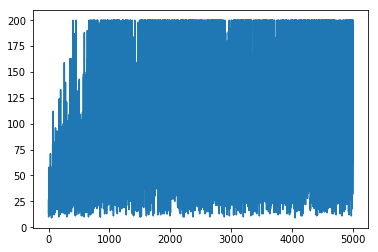

In [51]:
plt.plot(total_reward)